In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from scipy.stats import chi2_contingency, sem
from scipy.stats import ttest_ind

# Load Dataset for Analysis
df=pd.read_csv("/your path/data.csv",encoding='utf8',low_memory=False)
df_event_study = pd.read_csv("/your path/Fig3_event_study_data.csv", encoding='utf8')
df_did_pivot=pd.read_csv("/your path/Fig4_did_pivot_data.csv", encoding='utf8')

# **1 Figure 2**

## ***1.1 Data Computing</font>***

In [3]:
# ----------------------------------------------------------------------------------------------------------------------------
# ===================================================Core: attrition rule=====================================================
# ----------------------------------------------------------------------------------------------------------------------------
def _first_three_zero_start(series_by_year, start_year, end_year):
    for y in range(start_year, end_year - 1):  # y, y+1, y+2
        if (series_by_year.loc[y] == 0) and (series_by_year.loc[y + 1] == 0) and (series_by_year.loc[y + 2] == 0):
            return y
    return None

def build_survival_table(df, start_year, end_year,
                        id_col="author_id",
                        year_col="year",
                        count_col="log_paper_count",
                        treat_col="treat"):

    d = df[(df[year_col] >= start_year) & (df[year_col] <= end_year)].copy()
    d = d.sort_values([id_col, year_col])

    rows = []
    years = list(range(start_year, end_year + 1))

    for aid, g in d.groupby(id_col):
        g = g.set_index(year_col).sort_index()
        treat_series = g[treat_col].dropna()
        if len(treat_series) == 0:
            continue
        treat = int(treat_series.iloc[0])
        s = g.reindex(years)[count_col]
        death_start = _first_three_zero_start(s, start_year, end_year)
        if death_start is not None:
            event = 1
            duration = death_start - start_year 
        else:
            event = 0
            duration = end_year - start_year    

        rows.append([aid, treat,  duration, event])

    surv = pd.DataFrame(rows, columns=[id_col, "treat", "duration", "event"])
    assert len(surv) == surv[id_col].nunique(), " "

    return surv

def perform_km_analysis_correct(surv_df, start_year, end_year):
    
    treat = surv_df[surv_df["treat"] == 1]
    ctrl  = surv_df[surv_df["treat"] == 0]


    km_treat = KaplanMeierFitter().fit(treat["duration"], event_observed=treat["event"], label="Treatment Group")
    km_ctrl  = KaplanMeierFitter().fit(ctrl["duration"],  event_observed=ctrl["event"],  label="Control Group")


    # log-rank：treat vs control
    lr_tc = logrank_test(
        treat["duration"], ctrl["duration"],
        event_observed_A=treat["event"], event_observed_B=ctrl["event"]
    )
    return km_treat, km_ctrl,  lr_tc.p_value

# ----------------------------------------------------------------------------------------------------------------------------
# ===================================================Fig2A: Correct survival analysis=========================================
# ----------------------------------------------------------------------------------------------------------------------------

# 2014–2018
surv_14_18 = build_survival_table(df, 2014, 2018)
kmf_treat_14_18, kmf_control_14_18,  \
p_treatment_vs_control_14_18 = perform_km_analysis_correct(surv_14_18, 2014, 2018)

# 2019–2023
surv_19_23 = build_survival_table(df, 2019, 2023)
kmf_treat_19_23, kmf_control_19_23, \
p_treatment_vs_control_19_23 = perform_km_analysis_correct(surv_19_23, 2019, 2023)

# 2014–2023
surv_14_23 = build_survival_table(df, 2014, 2023)
kmf_treat_14_23, kmf_control_14_23,  \
p_treatment_vs_control_14_23 = perform_km_analysis_correct(surv_14_23, 2014, 2023)

# ----------------------------------------------------------------------------------------------------------------------------
# ===================================================Fig2B: Ethnic disparity (keep, but ensure death_2019 is consistent)=======
# ----------------------------------------------------------------------------------------------------------------------------

death_2019_map = surv_19_23.set_index("author_id")["event"].to_dict()
df["death_2019"] = df["author_id"].map(death_2019_map)

def analyze_ethnic_disparity(df, group_value):
    df_group = df[df["treat"] == group_value].drop_duplicates(subset="author_id")

    total_asian = df_group[df_group["race"] == "asian"]["author_id"].nunique()
    total_non_asian = df_group[df_group["race"] != "asian"]["author_id"].nunique()

    df_leave = df_group[df_group["death_2019"] == 1]
    leave_asian = df_leave[df_leave["race"] == "asian"]["author_id"].nunique()
    leave_non_asian = df_leave[df_leave["race"] != "asian"]["author_id"].nunique()

    prop_total_asian = total_asian / (total_asian + total_non_asian) if (total_asian + total_non_asian) else 0
    prop_leave_asian = leave_asian / (leave_asian + leave_non_asian) if (leave_asian + leave_non_asian) else 0

    se_total_asian = np.sqrt(prop_total_asian * (1 - prop_total_asian) / (total_asian + total_non_asian)) if (total_asian + total_non_asian) else 0
    se_leave_asian = np.sqrt(prop_leave_asian * (1 - prop_leave_asian) / (leave_asian + leave_non_asian)) if (leave_asian + leave_non_asian) else 0

    return {
        "total_asian": total_asian,
        "total_non_asian": total_non_asian,
        "leave_asian": leave_asian,
        "leave_non_asian": leave_non_asian,
        "prop_total_asian": prop_total_asian,
        "prop_leave_asian": prop_leave_asian,
        "se_total_asian": se_total_asian,
        "se_leave_asian": se_leave_asian
    }

results_treat = analyze_ethnic_disparity(df, 1)
results_control = analyze_ethnic_disparity(df, 0)

table_treat = [
    [results_treat["leave_asian"], results_treat["total_asian"] - results_treat["leave_asian"]],
    [results_treat["leave_non_asian"], results_treat["total_non_asian"] - results_treat["leave_non_asian"]]
]
chi2_treat, p_treat, _, _ = chi2_contingency(table_treat)

table_control = [
    [results_control["leave_asian"], results_control["total_asian"] - results_control["leave_asian"]],
    [results_control["leave_non_asian"], results_control["total_non_asian"] - results_control["leave_non_asian"]]
]
chi2_control, p_control, _, _ = chi2_contingency(table_control)

df_leave_all = df[df["death_2019"] == 1].drop_duplicates(subset="author_id")

asian_control = df_leave_all[(df_leave_all["race"] == "asian") & (df_leave_all["treat"] == 0)]["author_id"].nunique()
asian_treat = df_leave_all[(df_leave_all["race"] == "asian") & (df_leave_all["treat"] == 1)]["author_id"].nunique()
non_asian_control = df_leave_all[(df_leave_all["race"] != "asian") & (df_leave_all["treat"] == 0)]["author_id"].nunique()
non_asian_treat = df_leave_all[(df_leave_all["race"] != "asian") & (df_leave_all["treat"] == 1)]["author_id"].nunique()

table_leave = [
    [asian_control, asian_treat],
    [non_asian_control, non_asian_treat]
]
chi2_leave, p_leave, _, _ = chi2_contingency(table_leave)


# ----------------------------------------------------------------------------------------------------------------------------
# ===================================================Fig2C: Field heterogeneity (keep, based on death_2019)===================
# ----------------------------------------------------------------------------------------------------------------------------

field_mapping = {
    "BIOLOGICAL SCIENCES": "Biological & Biomedical Sciences",
    "BIOMEDICAL AND CLINICAL SCIENCES": "Biological & Biomedical Sciences",
    "HEALTH SCIENCES": "Biological & Biomedical Sciences",
    "AGRICULTURAL, VETERINARY AND FOOD SCIENCES": "Biological & Biomedical Sciences",
    "PHYSICAL SCIENCES": "Mathematical and Physical Sciences",
    "CHEMICAL SCIENCES": "Mathematical and Physical Sciences",
    "MATHEMATICAL SCIENCES": "Mathematical and Physical Sciences",
    "EARTH SCIENCES": "Earth & Environmental Sciences",
    "ENVIRONMENTAL SCIENCES": "Earth & Environmental Sciences",
    "ENGINEERING": "Engineering & Computing Science",
    "INFORMATION AND COMPUTING SCIENCES": "Engineering & Computing Science"
}

df["field_group"] = df["filed_0_string"].map(field_mapping)

df_treat = df[df["treat"] == 1].drop_duplicates("author_id")
df_control = df[df["treat"] == 0].drop_duplicates("author_id")

treat_leave = df_treat[df_treat["death_2019"] == 1]["field_group"].value_counts()
treat_total = df_treat["field_group"].value_counts()
treat_ratio = (treat_leave / treat_total).fillna(0)

control_leave = df_control[df_control["death_2019"] == 1]["field_group"].value_counts()
control_total = df_control["field_group"].value_counts()
control_ratio = (control_leave / control_total).fillna(0)

treat_se = {}
control_se = {}

for field in field_mapping.values():
    tl = treat_leave.get(field, 0)
    tt = treat_total.get(field, 0)
    cl = control_leave.get(field, 0)
    ct = control_total.get(field, 0)

    treat_se[field] = np.sqrt((tl/tt) * (1 - (tl/tt)) / tt) if tt > 0 else 0
    control_se[field] = np.sqrt((cl/ct) * (1 - (cl/ct)) / ct) if ct > 0 else 0

sorted_fields = treat_ratio.sort_values(ascending=False).index.tolist()
treat_ratio = treat_ratio.loc[sorted_fields]
control_ratio = control_ratio.loc[sorted_fields]
treat_se = pd.Series(treat_se).loc[sorted_fields]
control_se = pd.Series(control_se).loc[sorted_fields]

p_values = []
for field in sorted_fields:
    tl = treat_leave.get(field, 0)
    tt = treat_total.get(field, 0)
    cl = control_leave.get(field, 0)
    ct = control_total.get(field, 0)

    contingency = np.array([
        [tl, tt - tl],
        [cl, ct - cl]
    ])

    try:
        chi2, p, _, _ = chi2_contingency(contingency)
    except ValueError:
        p = np.nan
    p_values.append(p)

## ***1.2 Draw Fig2***

/var/folders/gs/zcjwrkbd7l30gfdf87_jxdtw0000gn/T/ipykernel_59044/1618170055.py:121: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_height = max(treat_ratio[i], control_ratio[i])


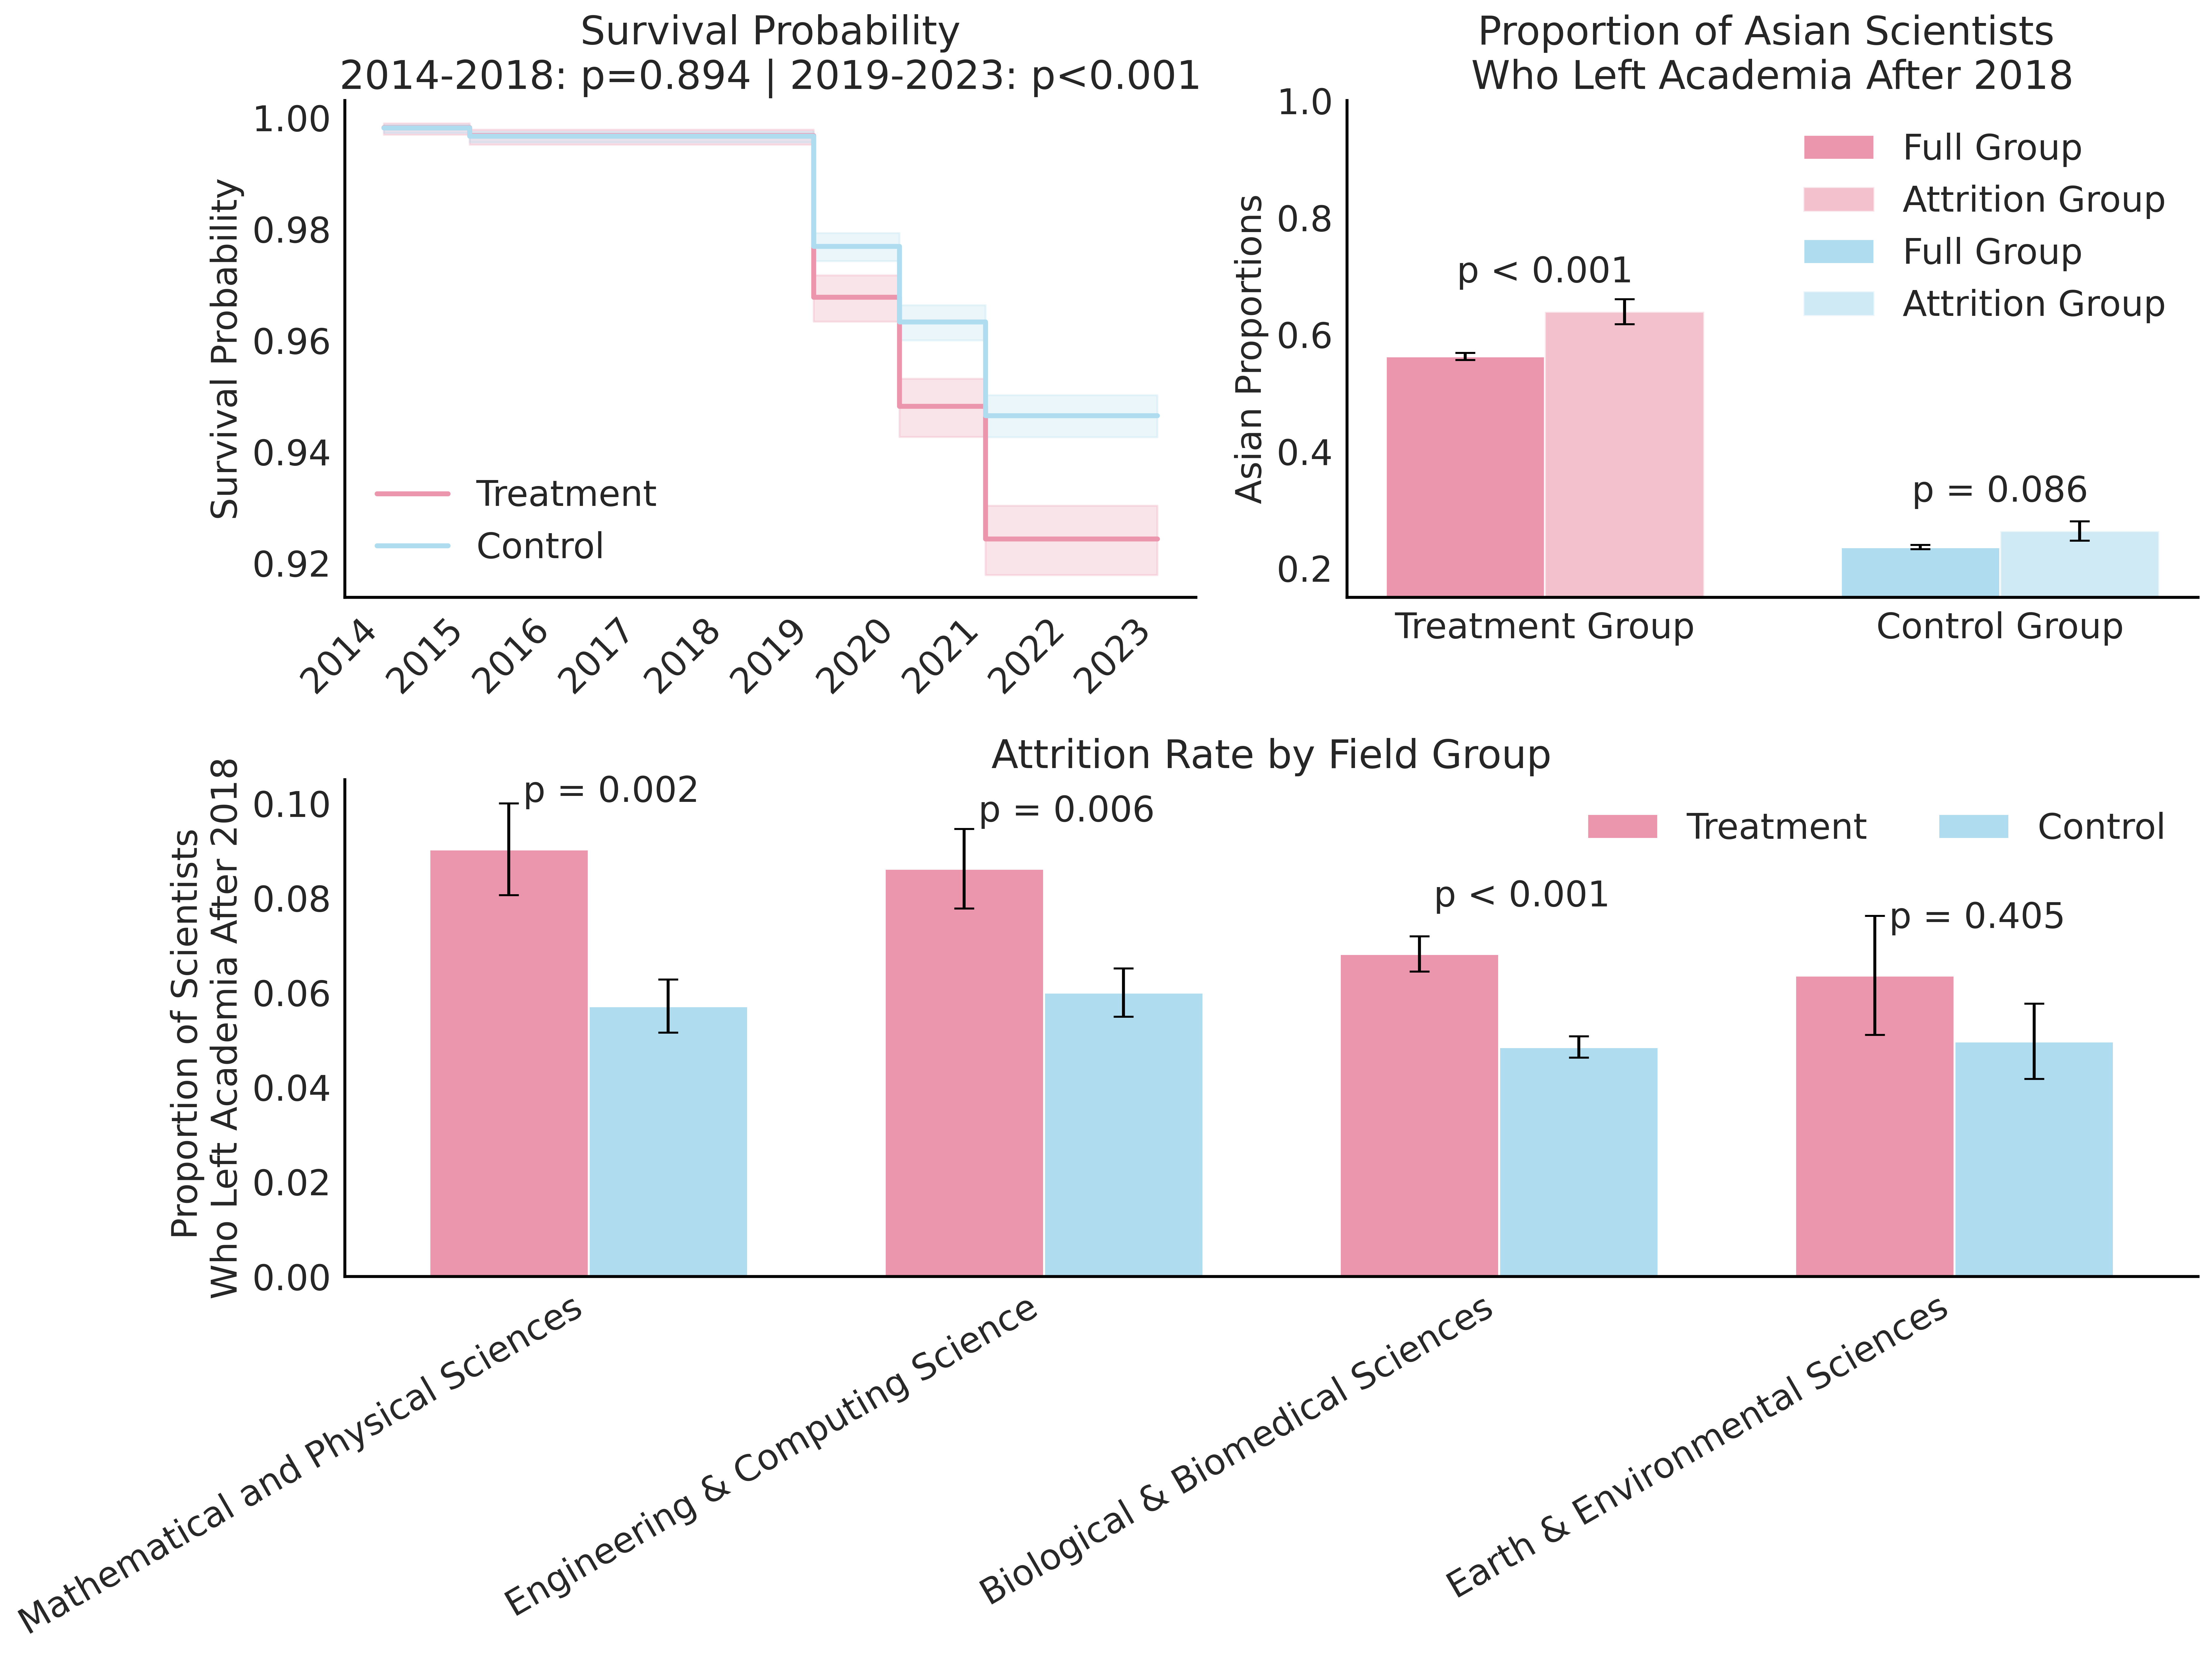

In [5]:
sns.set_style("whitegrid")  
plt.rcParams['font.family'] = 'DejaVu Sans'  
plt.rcParams['font.size'] = 18  
plt.rcParams['axes.labelsize'] = 20  
plt.rcParams['axes.titlesize'] = 20  
plt.rcParams['legend.fontsize'] = 18  
plt.rcParams['xtick.labelsize'] = 18  
plt.rcParams['ytick.labelsize'] = 18  

fig = plt.figure(figsize=(16, 12), dpi=500) 
gs = fig.add_gridspec(2, 2)  
ax1 = fig.add_subplot(gs[0, 0])  
ax2 = fig.add_subplot(gs[0, 1])  
ax3 = fig.add_subplot(gs[1, :])  
colors = ['#eb96ad', '#afdcef']  
# ----------------------------------------------------------------------------------------------------------------------------
# ===================================================Figure 2A================================================================ 
# ----------------------------------------------------------------------------------------------------------------------------
# Plot survival curves for treatment and control groups
kmf_treat_14_23.plot_survival_function(
    ax=ax1, ci_show=True, color=colors[0], label='Treatment',
    linewidth=2.5, linestyle='-', marker='', markersize=8
)
kmf_control_14_23.plot_survival_function(
    ax=ax1, ci_show=True, color=colors[1], label='Control',
    linewidth=2.5, linestyle='-', marker='', markersize=8
)
def format_p(p):
    return "p<0.001" if p < 0.001 else f"p={p:.3f}"

ax1.set_title(
    f"Survival Probability\n"
    f"2014-2018: {format_p(p_treatment_vs_control_14_18)} | "
    f"2019-2023: {format_p(p_treatment_vs_control_19_23)}",
    fontsize=20
)
ax1.set_ylabel('Survival Probability', fontsize=18)
ax1.set_xticks(list(range(10)))
ax1.set_xticklabels(
    [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    fontsize=18, rotation=45, ha='right'
)
ax1.tick_params(axis='y', labelsize=18)
ax1.legend(fontsize=18, frameon=False, loc='lower left')
ax1.set_xlabel('', fontsize=18)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_linewidth(1.5)
ax1.spines['bottom'].set_linewidth(1.5)
ax1.spines['left'].set_color('black')
ax1.spines['bottom'].set_color('black')
ax1.grid(False)
# ----------------------------------------------------------------------------------------------------------------------------
# ===================================================Figure 2B================================================================ 
# ----------------------------------------------------------------------------------------------------------------------------
labels = ['Treatment Group', 'Control Group']
x = np.arange(len(labels))
bar_width = 0.35
# Heights of bars: total vs attrition groups
heights_treat = [results_treat["prop_total_asian"], results_treat["prop_leave_asian"]]
heights_control = [results_control["prop_total_asian"], results_control["prop_leave_asian"]]

se_treat = [results_treat["se_total_asian"], results_treat["se_leave_asian"]]
se_control = [results_control["se_total_asian"], results_control["se_leave_asian"]]
ax2.bar(x[0] - bar_width / 2, heights_treat[0], width=bar_width, label='Full Group',
        color=colors[0], linewidth=1)
ax2.bar(x[0] + bar_width / 2, heights_treat[1], width=bar_width, label='Attrition Group',
        color=colors[0], alpha=0.6, linewidth=1)
ax2.bar(x[1] - bar_width / 2, heights_control[0], width=bar_width, label='Full Group',
        color=colors[1], linewidth=1)
ax2.bar(x[1] + bar_width / 2, heights_control[1], width=bar_width, label='Attrition Group',
        color=colors[1], alpha=0.6, linewidth=1)
ax2.errorbar(x[0] - bar_width / 2, heights_treat[0], yerr=se_treat[0],
             fmt='none', capsize=5, capthick=1, color="black")
ax2.errorbar(x[0] + bar_width / 2, heights_treat[1], yerr=se_treat[1],
             fmt='none', capsize=5, capthick=1, color="black")
ax2.errorbar(x[1] - bar_width / 2, heights_control[0], yerr=se_control[0],
             fmt='none', capsize=5, capthick=1, color="black")
ax2.errorbar(x[1] + bar_width / 2, heights_control[1], yerr=se_control[1],
             fmt='none', capsize=5, capthick=1, color="black")
ax2.text(x=x[0], y=max(heights_treat) + 0.05,
         s=f'p < 0.001' if p_treat < 0.001 else f'p = {p_treat:.3f}', ha='center', fontsize=18)
ax2.text(x=x[1], y=max(heights_control) + 0.05,
         s=f'p < 0.001' if p_control < 0.001 else f'p = {p_control:.3f}', ha='center', fontsize=18)
ax2.set_xticks(x)
ax2.set_xticklabels(labels, fontsize=18)
ax2.tick_params(axis='y', labelsize=18)
ax2.set_ylim(0.15, 1)
ax2.set_ylabel('Asian Proportions', fontsize=18)
ax2.set_title("Proportion of Asian Scientists \nWho Left Academia After 2018", fontsize=20)
ax2.legend(frameon=False, fontsize=18, loc='upper right', ncol=1)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_linewidth(1.5)
ax2.spines['bottom'].set_linewidth(1.5)
ax2.spines['left'].set_color('black')
ax2.spines['bottom'].set_color('black')
ax2.grid(False)
# ----------------------------------------------------------------------------------------------------------------------------
# ===================================================Figure 2C================================================================ 
# ----------------------------------------------------------------------------------------------------------------------------
bar_width = 0.35
index = np.arange(len(sorted_fields))

ax3.bar(index - bar_width / 2, treat_ratio, bar_width, label='Treatment',
        color=colors[0], linewidth=1)
ax3.bar(index + bar_width / 2, control_ratio, bar_width, label='Control',
        color=colors[1], linewidth=1)
ax3.errorbar(index - bar_width / 2, treat_ratio, yerr=treat_se,
             fmt='none', ecolor='black', capsize=5, capthick=1)
ax3.errorbar(index + bar_width / 2, control_ratio, yerr=control_se,
             fmt='none', ecolor='black', capsize=5, capthick=1)
ax3.set_xticks(index)
ax3.set_xticklabels(sorted_fields, fontsize=18, rotation=30, ha='right')
ax3.set_ylabel('Proportion of Scientists \nWho Left Academia After 2018', fontsize=18)
ax3.set_title('Attrition Rate by Field Group', fontsize=20)
ax3.legend(frameon=False, loc='upper right', fontsize=18, ncol=2)
ax3.tick_params(axis='y', labelsize=18)
ax3.grid(False)
for i, p in enumerate(p_values):
    max_height = max(treat_ratio[i], control_ratio[i])
    ax3.text(index[i] + 0.05, max_height + 0.01,
             f'p < 0.001' if p < 0.001 else f'p = {p:.3f}', ha='center', fontsize=18)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_linewidth(1.5)
ax3.spines['bottom'].set_linewidth(1.5)
ax3.spines['left'].set_color('black')
ax3.spines['bottom'].set_color('black')
plt.tight_layout()
plt.show()

# **2 Table 1**

In [7]:
# Columns to test and their display titles
columns_to_test = [
    'log_federal_funding_amount', 
    'log_us_funding_amount', 
    'log_total_funding_amount',
    "pivot_size", 
    'career_age', 
    'log_paper_count', 
    'log_cf', 
    'log_new_us_collaborators_count'
]
titles = [
    "U.S. Federal Funding Amount", 
    "U.S. Funding Amount", 
    "Total Funding Amount",
    "Pivot Size", 
    "Career Age", 
    "# Papers", 
    "Cf", 
    "# New U.S. collaborators"
]
def ttest_by_period(df, start_year, end_year):
    df_period = df[(df['year'] >= start_year) & (df['year'] <= end_year)]
    mean_by_author = df_period.groupby("author_id")[columns_to_test + ["treat"]].mean(numeric_only=True).reset_index()
    print(f"\n{start_year}-{end_year}:\nVariable\tMean(Treat)\tMean(Control)\tDiff(Treat-Control)\tp-value")
    print("-"*80)
    for col, title in zip(columns_to_test, titles):
        df_temp = mean_by_author.dropna(subset=[col]) if col == "pivot_size" else mean_by_author
        treat_vals = df_temp.loc[df_temp["treat"] == 1, col]
        control_vals = df_temp.loc[df_temp["treat"] == 0, col]
        mean_treat = treat_vals.mean(skipna=True)
        mean_control = control_vals.mean(skipna=True)
        diff = mean_treat - mean_control
        if treat_vals.nunique() <= 1 or control_vals.nunique() <= 1:
            p_value = np.nan
        else:
            _, p_value = ttest_ind(treat_vals, control_vals, equal_var=False, nan_policy='omit')
        print(f"{title}\t{mean_treat:.3f}\t{mean_control:.3f}\t{diff:.3f}\t{p_value:.3f}")
    print("-"*80)
    print(f"Number of treatment group: {len(df[df['treat'] == 1]['author_id'].unique())}")
    print(f"Number of control group: {len(df[df['treat'] == 0]['author_id'].unique())}")
# Compute statistics for 2014-2018
ttest_by_period(df, 2014, 2018)
# Compute statistics for 2019-2023
ttest_by_period(df, 2019, 2023)


2014-2018:
Variable	Mean(Treat)	Mean(Control)	Diff(Treat-Control)	p-value
--------------------------------------------------------------------------------
U.S. Federal Funding Amount	8.534	8.608	-0.074	0.344
U.S. Funding Amount	8.678	8.755	-0.077	0.322
Total Funding Amount	8.806	8.844	-0.038	0.618
Pivot Size	0.507	0.505	0.002	0.479
Career Age	21.900	21.799	0.100	0.476
# Papers	1.907	1.912	-0.005	0.639
Cf	0.643	0.639	0.003	0.329
# New U.S. collaborators	2.234	2.255	-0.021	0.159
--------------------------------------------------------------------------------
Number of treatment group: 6926
Number of control group: 13685

2019-2023:
Variable	Mean(Treat)	Mean(Control)	Diff(Treat-Control)	p-value
--------------------------------------------------------------------------------
U.S. Federal Funding Amount	7.820	8.159	-0.339	0.000
U.S. Funding Amount	7.917	8.255	-0.338	0.000
Total Funding Amount	8.174	8.396	-0.222	0.005
Pivot Size	0.527	0.518	0.008	0.001
Career Age	26.900	26.799	0.100	0.476
#

# **3 Figure 3**

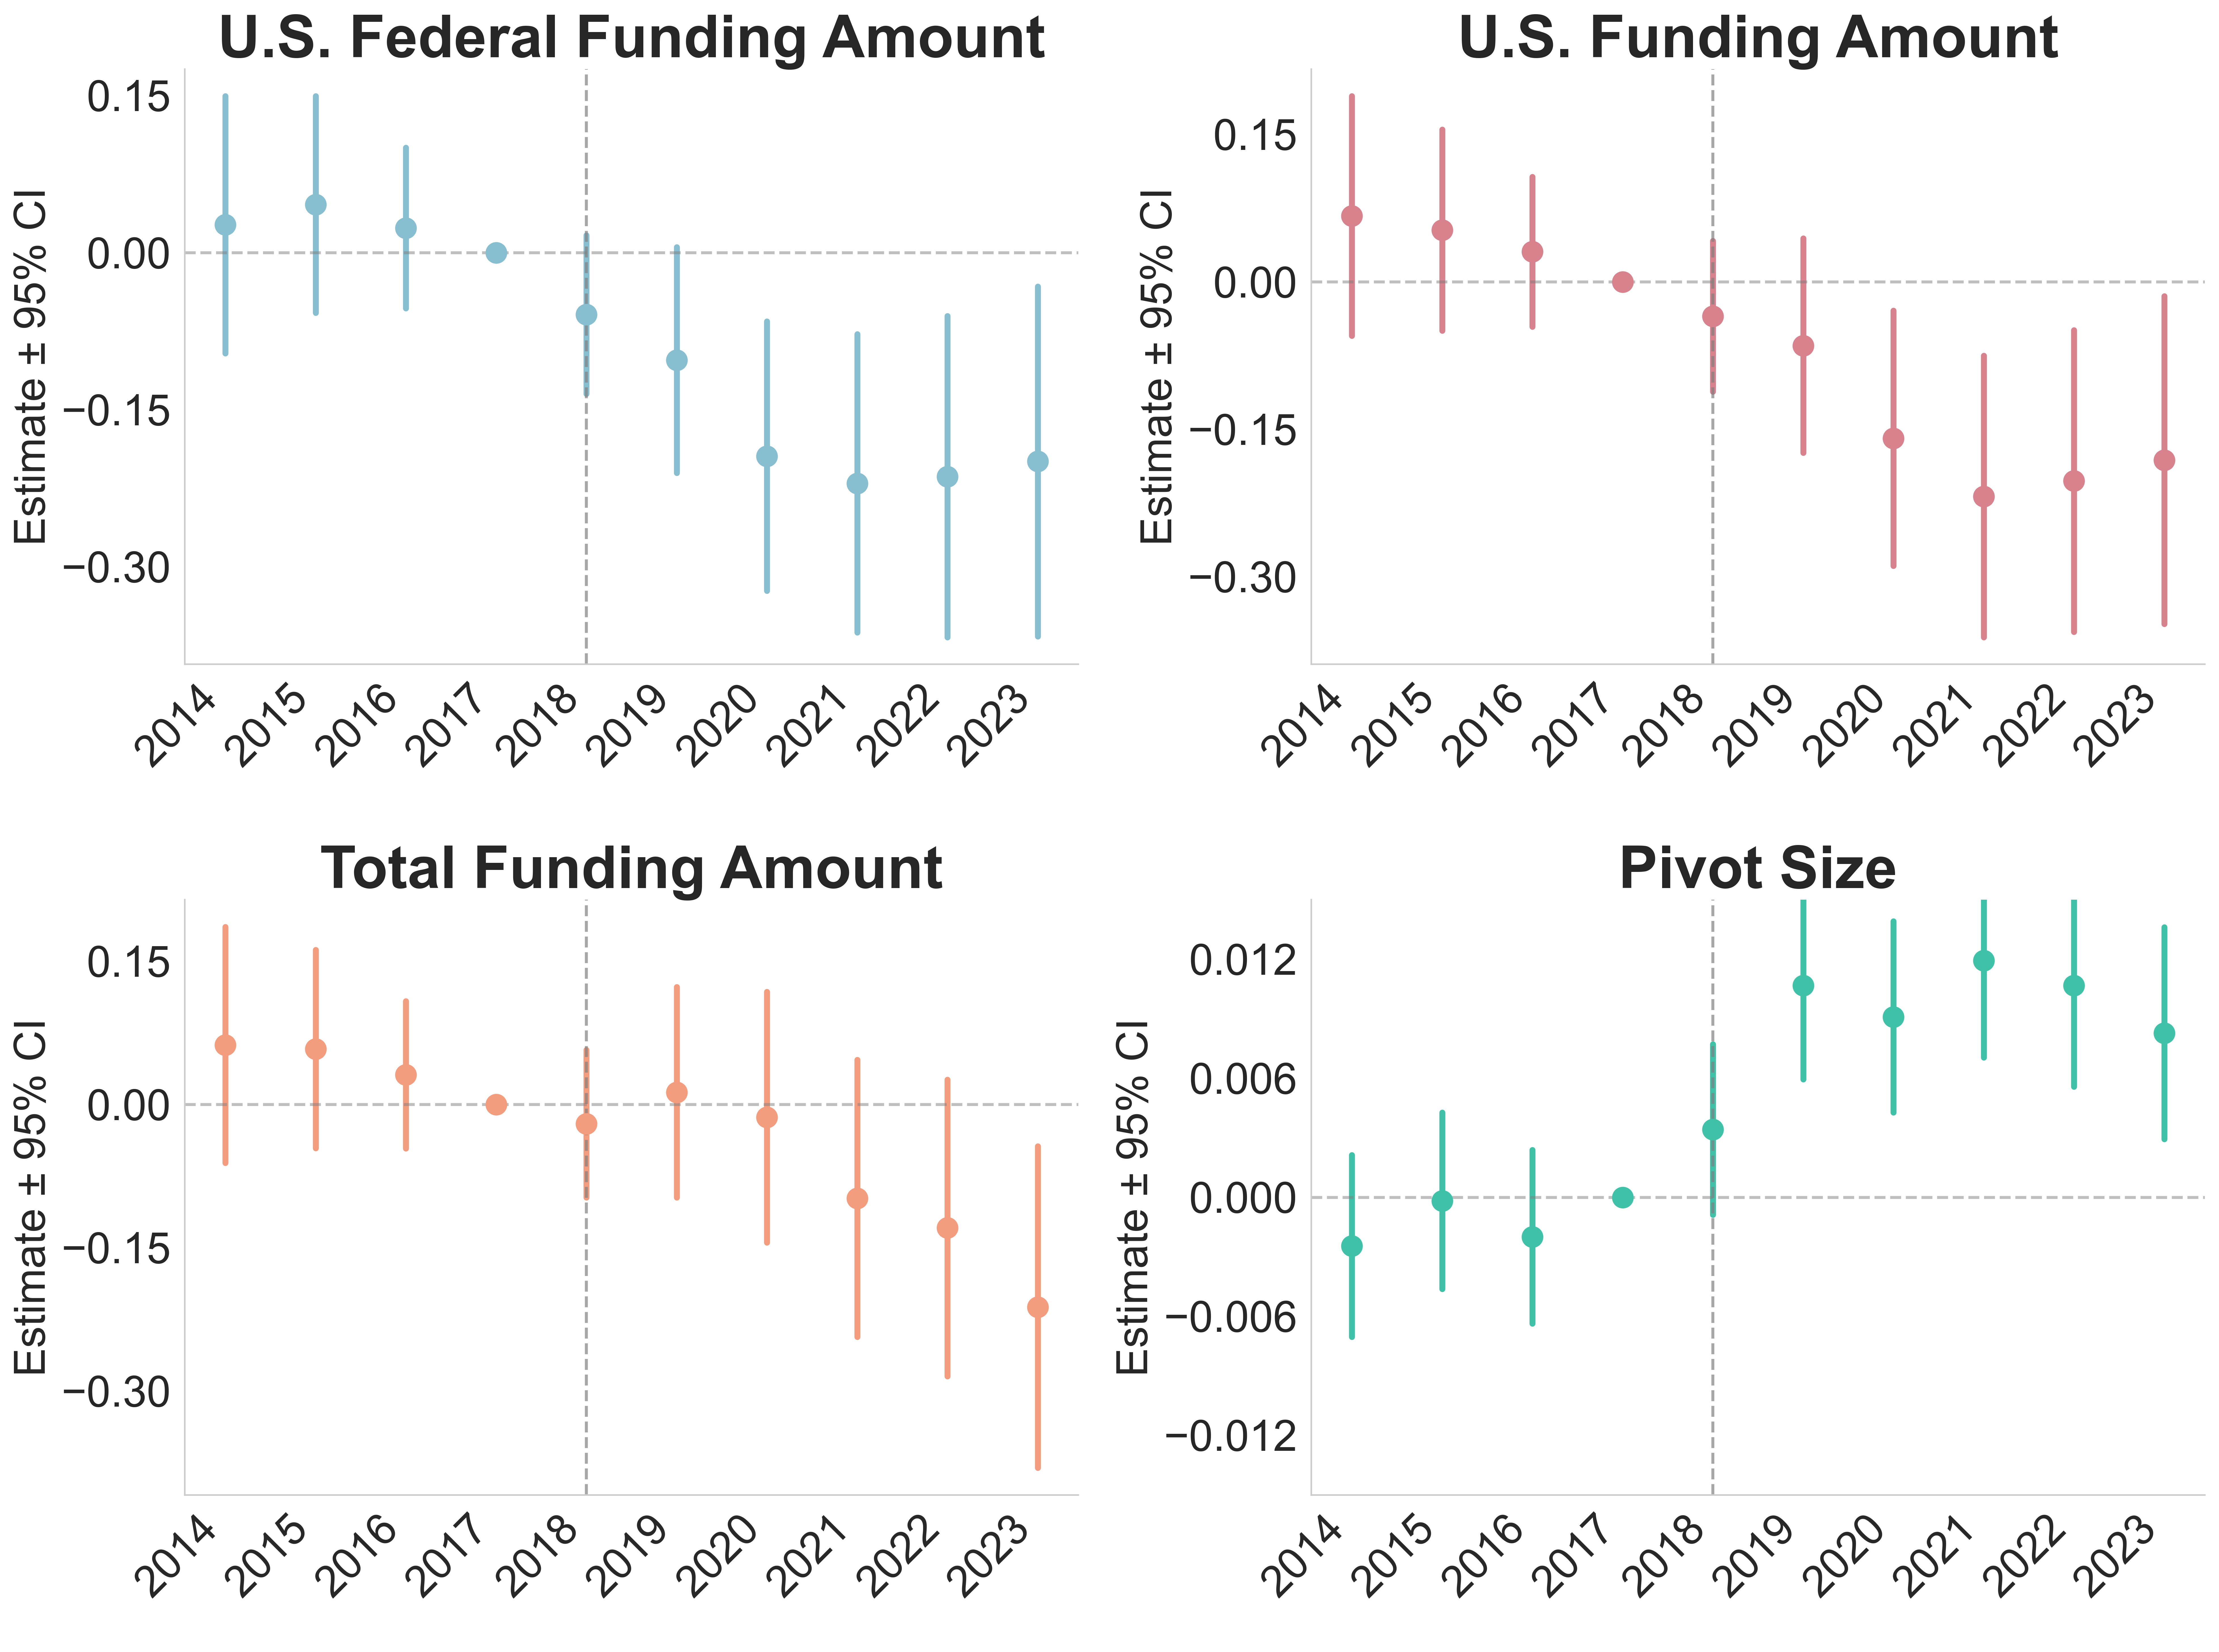

In [9]:
# Define models and extract estimates and confidence intervals
models = [
    ("b_log_federal_funding_amount", "min95_log_federal_funding_amount", "max95_log_federal_funding_amount"),
    ("b_log_us_funding_amount", "min95_log_us_funding_amount", "max95_log_us_funding_amount"),
    ("b_log_total_funding_amount", "min95_log_total_funding_amount", "max95_log_total_funding_amount"),
    ("b_pivot_size", "min95_pivot_size", "max95_pivot_size")
]
estimates_list = []
conf_lowers = []
conf_uppers = []
for b_col, ci_low_col, ci_up_col in models:
    estimates_list.append(df_event_study[b_col].to_numpy())
    conf_lowers.append(df_event_study[ci_low_col].to_numpy())
    conf_uppers.append(df_event_study[ci_up_col].to_numpy())
years = np.array([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])
colors = [
    '#87bed0',  # light blue
    '#d7828c',  # pink
    '#f39c7e',  # orange
    '#40c2a8'   # green
]
titles = [
    'U.S. Federal Funding Amount',
    'U.S. Funding Amount',
    'Total Funding Amount',
    'Pivot Size'
]
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'sans-serif']
})
fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi=500)
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)
    for j, (est, low, up) in enumerate(zip(estimates_list[i], conf_lowers[i], conf_uppers[i])):
        ax.plot(years[j], est, 'o', color=colors[i], markersize=10, zorder=3)
        ax.plot([years[j], years[j]], [low, up], color=colors[i], linestyle='-', linewidth=3, zorder=1)
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5, zorder=1)
    ax.set_title(titles[i], fontsize=30, fontweight='bold')
    ax.set_xticks(years)
    ax.set_xticklabels(years, rotation=45, ha='right')
    ax.set_xlabel(' ', fontsize=14)
    ax.tick_params(axis='y', labelsize=22)
    ax.tick_params(axis='x', labelsize=22)
    ax.set_ylabel('Estimate ± 95% CI', fontsize=22)
    if i == 3:  
        ax.set_ylim(-0.015, 0.015)
    ax.yaxis.set_major_locator(mticker.MaxNLocator(5))
    ax.axvline(x=2018, color='gray', linestyle='--', alpha=0.7, zorder=1)
plt.tight_layout()
plt.show()


# **4 Figure 4**

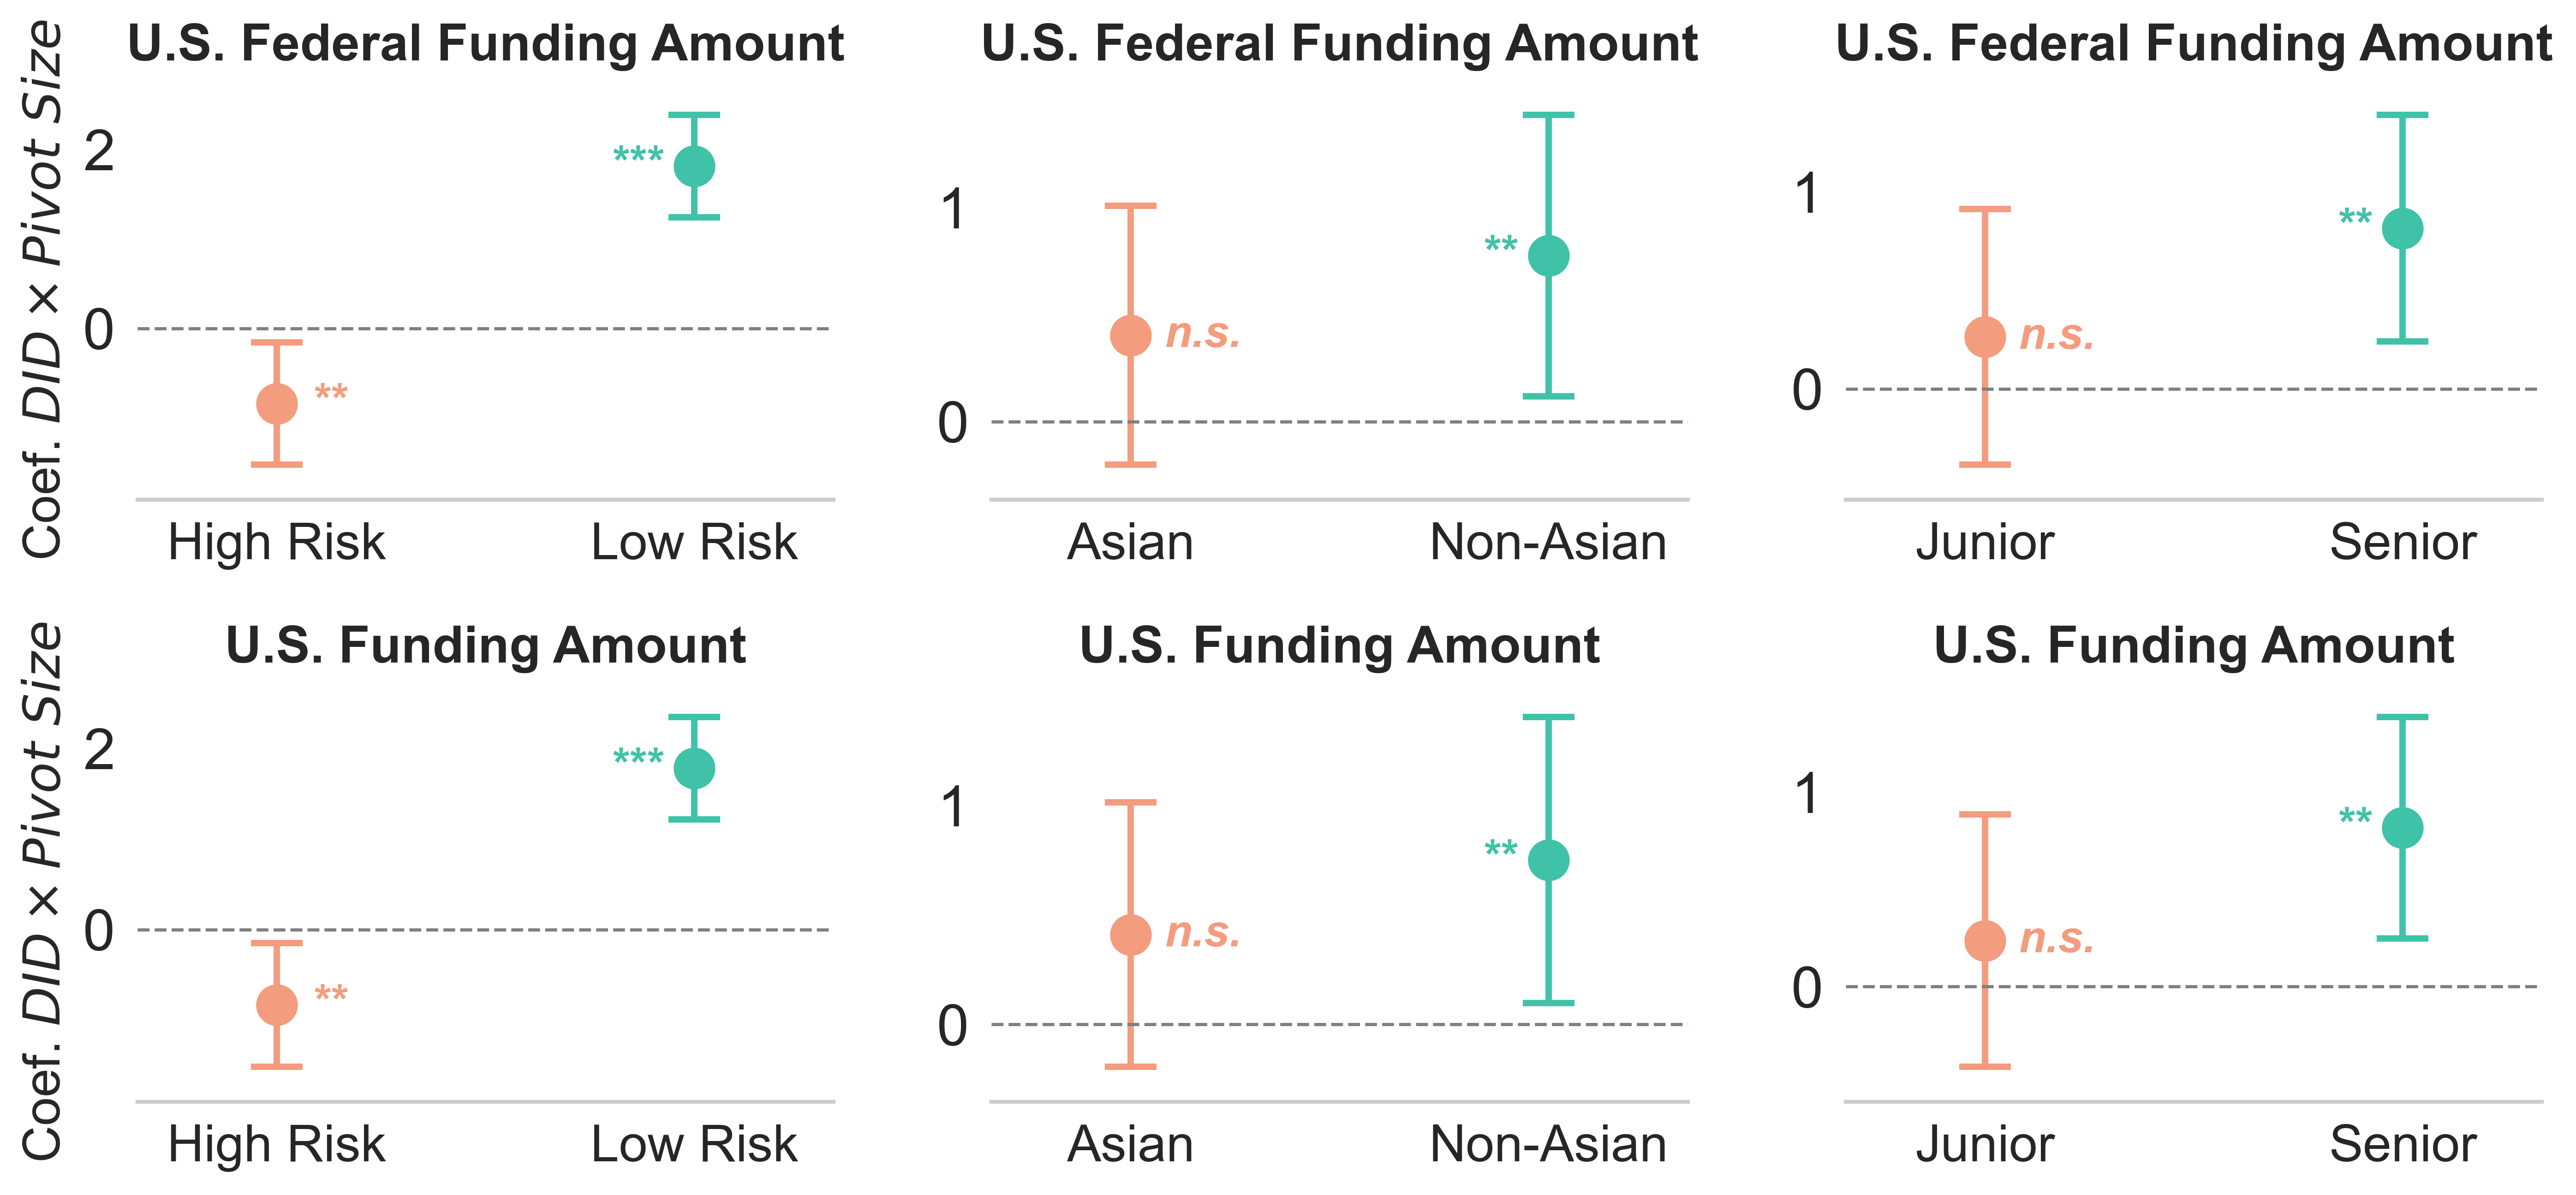

In [11]:
# Define a function to generate pivot dictionaries
def make_pivot_dict(df, prefix, categories):
    """
    df: DataFrame containing regression results
    prefix: column prefix, e.g., 'log_federal_funding_amount'
    categories: list of categories, e.g., ['high_risk','low_risk']
    """
    return {cat: {
                'coef': df[f"b_{prefix}_{cat}"][0],
                'p': df[f"p_{prefix}_{cat}"][0],
                'ci': [
                    df[f"min95_{prefix}_{cat}"][0],
                    df[f"max95_{prefix}_{cat}"][0]
                ]
            } for cat in categories}

field_federal_data = {'federal_funding_pivot': make_pivot_dict(df_did_pivot, 'log_federal_funding_amount', ['high_risk','low_risk'])}
race_federal_data  = {'federal_funding_pivot': make_pivot_dict(df_did_pivot, 'log_federal_funding_amount', ['asian','non_asian'])}
age_federal_data   = {'federal_funding_pivot': make_pivot_dict(df_did_pivot, 'log_federal_funding_amount', ['junior','senior'])}
field_us_data      = {'us_funding_pivot': make_pivot_dict(df_did_pivot, 'log_us_funding_amount', ['high_risk','low_risk'])}
race_us_data       = {'us_funding_pivot': make_pivot_dict(df_did_pivot, 'log_us_funding_amount', ['asian','non_asian'])}
age_us_data        = {'us_funding_pivot': make_pivot_dict(df_did_pivot, 'log_us_funding_amount', ['junior','senior'])}
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 16,
    'axes.linewidth': 1.2,
    'xtick.major.width': 1.2,
    'ytick.major.width': 1.2,
    'figure.dpi': 500,
    'text.usetex': False
})

field_color = {'high_risk': '#f39c7e', 'low_risk': '#40c2a8'}
race_color  = {'asian': '#f39c7e', 'non_asian': '#40c2a8'}
age_color   = {'junior': '#f39c7e', 'senior': '#40c2a8'}
field_xlabels = ['High Risk', 'Low Risk']
race_xlabels  = ['Asian', 'Non-Asian']
age_xlabels   = ['Junior', 'Senior']

fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=False, sharey=False)
offset = 0.08  
def plot_ci(ax, data, color_dict, xlabels, title):
    categories = list(data.keys())
    coefs = [data[c]['coef'] for c in categories]
    ps = [data[c]['p'] for c in categories]
    cis = [data[c]['ci'] for c in categories]

    x = np.array([0.2, 0.8])
    all_ys = [ci[0] for ci in cis] + [ci[1] for ci in cis]
    y_min, y_max = min(all_ys)-0.1*(max(all_ys)-min(all_ys)), max(all_ys)+0.1*(max(all_ys)-min(all_ys))
    for j in range(len(x)):
        color = color_dict[categories[j]]
        signif = "***" if ps[j]<0.001 else "**" if ps[j]<0.05 else "*" if ps[j]<0.1 else "n.s."
        ci_lower, ci_upper = cis[j]
        ax.errorbar(
            x[j],
            coefs[j],
            yerr=[[coefs[j]-ci_lower], [ci_upper-coefs[j]]],
            fmt='o',
            capsize=8,
            color=color,
            markersize=12,
            elinewidth=2,
            capthick=2
        )
        ax.text(
            x[j]+0.6*(-offset if j==1 else offset),
            coefs[j],
            signif,
            ha='left' if j==0 else 'right',
            va='center',
            fontsize=14,
            fontstyle='italic',
            color=color,
            fontweight='bold'
        )

    ax.set_ylim(y_min, y_max)
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.set_xlim(0, 1)
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels, fontsize=16)
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(False)
plot_ci(axes[0,0], field_federal_data['federal_funding_pivot'], field_color, field_xlabels, 'U.S. Federal Funding Amount')
plot_ci(axes[0,1], race_federal_data['federal_funding_pivot'], race_color, race_xlabels, 'U.S. Federal Funding Amount')
plot_ci(axes[0,2], age_federal_data['federal_funding_pivot'], age_color, age_xlabels, 'U.S. Federal Funding Amount')
axes[0,0].set_ylabel(r'Coef. $\it{DID} \times \it{Pivot\ Size}$', fontsize=16)
plot_ci(axes[1,0], field_us_data['us_funding_pivot'], field_color, field_xlabels, 'U.S. Funding Amount')
plot_ci(axes[1,1], race_us_data['us_funding_pivot'], race_color, race_xlabels, 'U.S. Funding Amount')
plot_ci(axes[1,2], age_us_data['us_funding_pivot'], age_color, age_xlabels, 'U.S. Funding Amount')
axes[1,0].set_ylabel(r'Coef. $\it{DID} \times \it{Pivot\ Size}$', fontsize=16)
plt.tight_layout(rect=[0.05, 0.05, 1, 0.96])
plt.show()